## Installing Packages and Importing Dataset

In [1]:
# Intalling the necessary libraries
!pip install numpy matplotlib scikit-learn opencv-python gdown imgaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 6.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# Downloading the ZIP file from drive link and unzipping the file
!gdown 'https://drive.google.com/uc?id=1JGhzGQoGEBY-8Phw8LUSsbM0-78kbQ_1' -O 'dataset.zip'
!unzip -q 'dataset.zip' -d './dataset'

Downloading...
From (original): https://drive.google.com/uc?id=1JGhzGQoGEBY-8Phw8LUSsbM0-78kbQ_1
From (redirected): https://drive.google.com/uc?id=1JGhzGQoGEBY-8Phw8LUSsbM0-78kbQ_1&confirm=t&uuid=7be7d524-93e5-4d26-aefe-cabad110656e
To: /kaggle/working/dataset.zip
100%|███████████████████████████████████████| 94.5M/94.5M [00:00<00:00, 163MB/s]


In [3]:
# Importing Required Libraries
import os
import pickle
import numpy as np
import cv2
from skimage.feature import local_binary_pattern, hog
from skimage import exposure
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import imgaug.augmenters as iaa


In [4]:
# Function to count number of Images in each class
def count_images_by_category(base_dir):
    
    category_counts = {} #dictionary to store the count of images

    # Check each subdirectory in the base directory
    for root, dirs, files in os.walk(base_dir):
        if files: 
            category = os.path.basename(root)
            images = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
            category_counts[category] = len(images)

    return category_counts


dataset_directory = './dataset/dataset_full' 


image_counts = count_images_by_category(dataset_directory)

# Displaying the number of Images for each category
print("Image count by category:")
for category, count in image_counts.items():
    print(f"{category}: {count} images")


Image count by category:
Building: 500 images
Mountains: 500 images
Sea: 500 images
Forest: 2745 images
Glacier: 500 images
Streets: 500 images


## Data Pre-processing and Feature Engieering


In [5]:
# Function for Data Augmenatation
def create_augmentation_pipeline():
    return iaa.Sequential([
        iaa.Fliplr(0.5),  
        iaa.Crop(percent=(0, 0.1)), 
        iaa.LinearContrast((0.75, 1.5)),  
        iaa.Multiply((0.8, 1.2)), 
        iaa.Affine(
            rotate=(-25, 25),  
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}  
        )
    ], random_order=True)  

In [6]:
# Function for Image Processing and Feature Extraction
def preprocess_and_extract_features(input_data, fixed_length=45000):
    
    if isinstance(input_data, str): 
        img = cv2.imread(input_data, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Failed to load image at {input_data}")
            return None
    elif isinstance(input_data, np.ndarray): 
        img = input_data
    else:
        raise TypeError("Input data must be a filepath string or an image array")

    # Converting the images from RGB to Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Extracting HOG Features
    hog_features, hog_image = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                                  cells_per_block=(1, 1), visualize=True, feature_vector=True)
    hog_features = np.array(hog_features)
    
    # Extracting LBP features
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    lbp_features = lbp.flatten()

    # SIFT features
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None:
        sift_features = descriptors.flatten()
    else:
        sift_features = np.array([])

    # Combining all the features 
    combined_features = np.concatenate((hog_features, lbp_features, sift_features))

    # Normalizing the feature vector
    if combined_features.size > fixed_length:
        combined_features = combined_features[:fixed_length]  # Truncating the features to a fixed length to keep input homogenous
    else:
        combined_features = np.pad(combined_features, (0, max(0, fixed_length - combined_features.size)), 'constant')  # Padding with zeros to a fixed length to keep input homogenous

    return combined_features


# Function for Loading images and applying Feature Exctration
def load_images_and_extract_features(base_dir, fixed_length=45000, augment_classes=None):
    categories = ['Sea', 'Forest', 'Glacier', 'Building', 'Streets', 'Mountains']
    data = []
    aug = create_augmentation_pipeline()
    for category in categories:
        category_path = os.path.join(base_dir, category)
        images = [img for img in os.listdir(category_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for image_name in images:
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path)
            if image is not None:
                features = preprocess_and_extract_features(image, fixed_length)  
                if features is not None:
                    data.append((features, category))
                if augment_classes and category in augment_classes:
                    for _ in range(5):  # Create 5 augmented versions
                        aug_image = aug(image=image)
                        features = preprocess_and_extract_features(aug_image, fixed_length)  
                        if features is not None:
                            data.append((features, category))
    return data



In [7]:
# Oversampling by Data Augmentation for Minority Classes
dataset_directory = './dataset/dataset_full'
augment_classes = ['Sea', 'Building', 'Streets', 'Mountains', 'Glacier']
dataset = load_images_and_extract_features(dataset_directory, augment_classes=augment_classes)
print(f"Total images loaded and processed: {len(dataset)}")

Total images loaded and processed: 17745


In [8]:
# Label Encoding

features = np.array([item[0] for item in dataset])
labels = np.array([item[1] for item in dataset])
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

# Creating a dictionary that maps class names to encoded labels
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

print("Label mapping:")
print(label_mapping)

Label mapping:
{'Building': 0, 'Forest': 1, 'Glacier': 2, 'Mountains': 3, 'Sea': 4, 'Streets': 5}


In [9]:
#Train-Test Split and Standardising 

X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
pca = PCA(n_components=150)

# Fit PCA on the training set only, then transform both the training and test sets
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


## Model Training and Evaluation

In [21]:
# Training the SVM Classifier 
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_pca, y_train)

# Evaluating the SVM Classifier
svm_predictions = svm_classifier.predict(X_test_pca)
print("SVM Classification Report with PCA:")
print(classification_report(y_test, svm_predictions))

SVM Classification Report with PCA:
              precision    recall  f1-score   support

           0       0.67      0.60      0.64       620
           1       0.91      0.95      0.93       554
           2       0.58      0.60      0.59       616
           3       0.53      0.57      0.55       579
           4       0.58      0.55      0.57       588
           5       0.62      0.65      0.63       592

    accuracy                           0.65      3549
   macro avg       0.65      0.65      0.65      3549
weighted avg       0.65      0.65      0.65      3549



In [16]:
# Training and Evaluating the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_pca, y_train)

# Evaluating the Decision Tree Classifier
dt_predictions = dt_classifier.predict(X_test_pca)
print("Decision Tree Classification Report with PCA:")
print(classification_report(y_test, dt_predictions))

Decision Tree Classification Report with PCA:
              precision    recall  f1-score   support

           0       0.45      0.40      0.42       620
           1       0.86      0.82      0.84       554
           2       0.37      0.41      0.39       616
           3       0.37      0.37      0.37       579
           4       0.40      0.41      0.40       588
           5       0.42      0.43      0.43       592

    accuracy                           0.47      3549
   macro avg       0.48      0.47      0.47      3549
weighted avg       0.47      0.47      0.47      3549



In [17]:
# Training Random Forest Classifier Model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of trees and other parameters
rf_classifier.fit(X_train_pca, y_train)

#Evaluating the Random Forest Model
rf_predictions = rf_classifier.predict(X_test_pca)
print("Random Forest Classification Report with PCA:")
print(classification_report(y_test, rf_predictions))


Random Forest Classification Report with PCA:
              precision    recall  f1-score   support

           0       0.67      0.47      0.55       620
           1       0.90      0.94      0.92       554
           2       0.50      0.53      0.51       616
           3       0.45      0.50      0.47       579
           4       0.53      0.59      0.56       588
           5       0.59      0.60      0.60       592

    accuracy                           0.60      3549
   macro avg       0.61      0.60      0.60      3549
weighted avg       0.61      0.60      0.60      3549



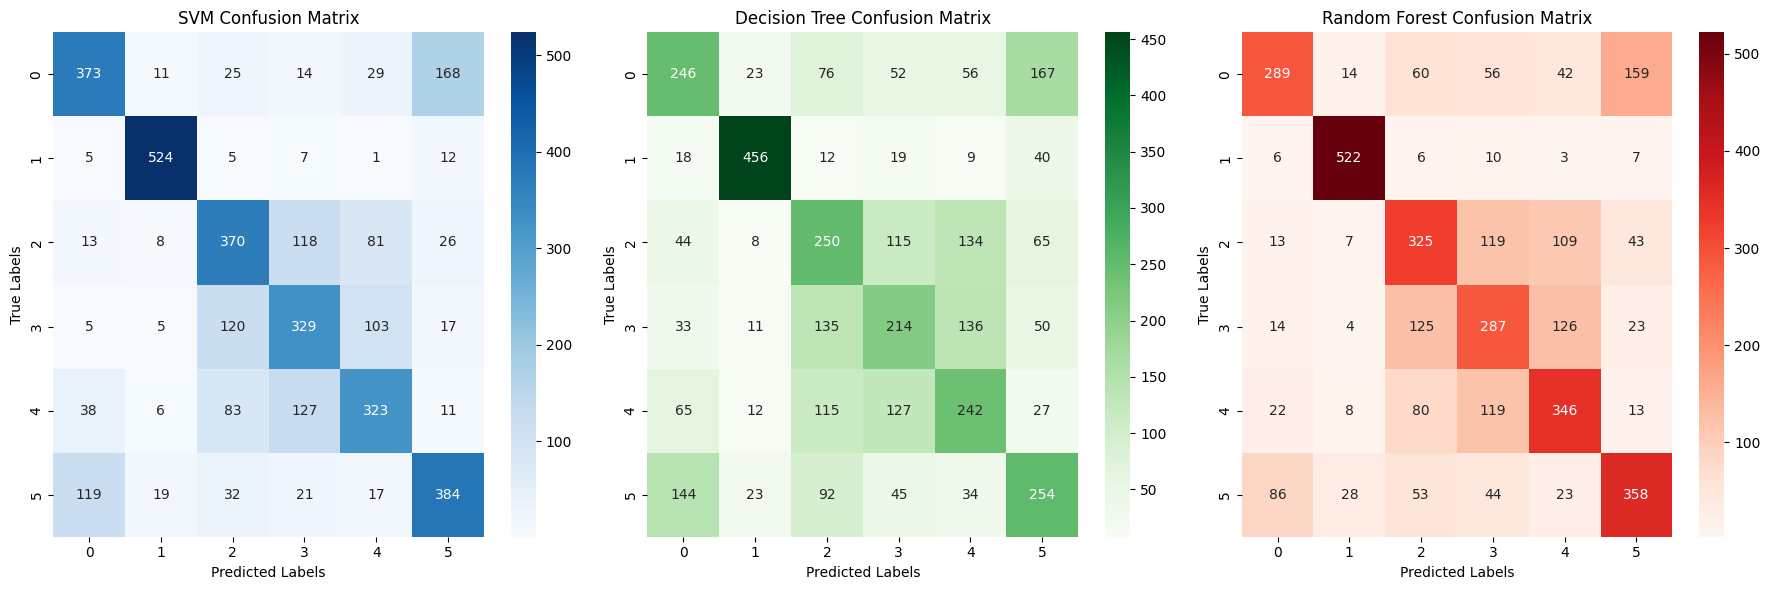

In [20]:
# Generating confusion matrices
svm_conf_matrix = confusion_matrix(y_test, svm_predictions)
dt_conf_matrix = confusion_matrix(y_test, dt_predictions)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)

# Plotting the Confusion Matrices
plt.figure(figsize=(18, 6))  

# SVM Confusion Matrix
plt.subplot(1, 3, 1) 
sns.heatmap(svm_conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Decision Tree Confusion Matrix
plt.subplot(1, 3, 2)  
sns.heatmap(dt_conf_matrix, annot=True, fmt="d", cmap='Greens')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Random Forest Confusion Matrix
plt.subplot(1, 3, 3)  
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap='Reds')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout() 
plt.show()


## Saving the SVM Model and PCA for Deployment

In [15]:
import pickle

# Saving the SVM classifier using pickle
with open('svm_classifier.pkl', 'wb') as file:
    pickle.dump(svm_classifier, file)
print("SVM Model saved successfully.")

# Saving the PCA transformer using pickle
with open('pca_transformer.pkl', 'wb') as file:
    pickle.dump(pca, file)
print("PCA Model saved successfully.")


SVM Model saved successfully.
PCA Model saved successfully.
